In [811]:
using Pkg
Pkg.activate("../.")
using DifferentialEquations, Plots, GLM, DataFrames, StatsBase

#define structures
struct b_param
    B0::Float64
    E::Float64
end

struct parameters
    μ::b_param
    K::b_param
    r::b_param
end

function  boltz(B::b_param, T)
    B.B0 * exp(B.E * T)
end

#define functions
function parameters(μ0,Eμ,K0,EK,r0,Er)
    parameters(b_param(μ0,Eμ),b_param(K0,EK),b_param(r0,Er))
end

function dC!(dC,C,p,t)
    dC[1] = boltz(p.μ, C[2]) * C[1] * (1 - (C[1] / boltz(p.K, C[2])) )
    dC[2] = 2pi*cos(t*2pi)
end

function get_R(sol,t)
    boltz(sol.prob.p.r,sol(t)[2]) * sol(t)[1]
end

function get_T(sol,t)
   sol(t)[2]
end

Activating environment at `~/Documents/Work/Projects/Working/Bacterial_Interactions/Project.toml`


get_T (generic function with 1 method)

# Introduction
At the ecosystem scale, total respiratory carbon flux (i.e. the total amount of carbon being released from respiration), $R$ can be written as the product of mass specific respiratory flux (i.e. the amount of respiratory carbon released per unit biomass) $r$ And biomass $C$ in the system: 

\begin{equation}
    R = r C
\end{equation}
 
So in order to understand how temperature affects ecosystems scale carbon flux need to understand how it affects both mass specific flux $r$ and the distribution and amount of biomass within the system $C$. One potentially interesting thing to think about is whether these sensitivities vary over time and whether we expect to observe these changes in real time series. 

For mass-specific respiration the simplest assumption is that it remains constant over time (MTE would argue that this would be at $E_{r} \approx 0.65$) so the only way that $E_R$ can change over time is through changess in the amount of biomass with temperature. 


# How might biomass change with temperature?

Assuming that temperature follows some periodic function (i.e. cycles over time) there are several ways in which biomass can respond. One way to think about this is the relative timescales of biomass dynamics to temperature. 

## $\tau_{T} < \tau_{C}$ - temperature changes alot faster than biomass

In this regime temperature changes faster than biomass. This means that biomass will appear constant over the timescale of temperature oscilations. 

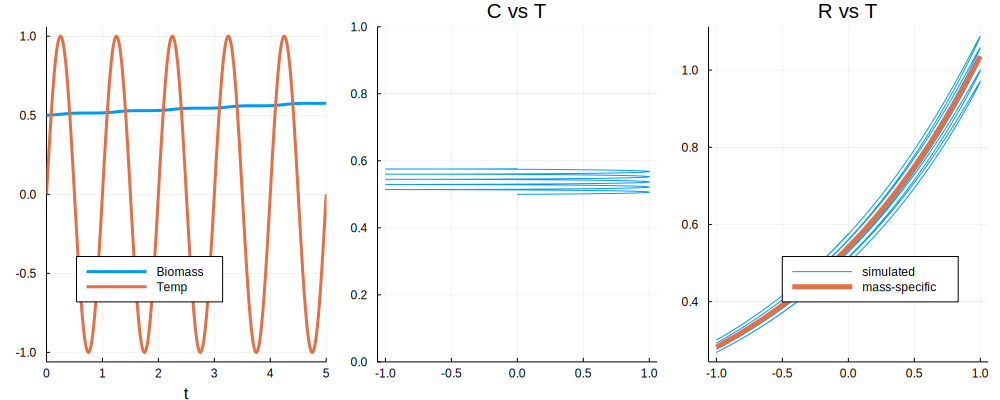

In [862]:
p = parameters(0.05,0.65,
                1.0,0.65, 
                1.0,0.65)

C0 = [0.5,0.0]
tspan = (0.0,5.0)

prob = ODEProblem(dC!,C0,tspan,p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, saveat = 0.01)

p1 = plot(sol, label = ["Biomass" "Temp"], legend = :bottomleft)

C = hcat(sol.u...)[1,:]
T = hcat(sol.u...)[2,:]
R = get_R.(Ref(sol),sol.t) 

p2 = plot(T,C, ylim = (0,1), title = "C vs T", legend = false)

r = boltz.(Ref(p.r),T) .* mean(C)
p3 = plot(T,R, title = "R vs T", label = "simulated", legend = :bottomright)
plot!(p3,T,r, label = "mass-specific", linewidth = 5)



plot(p1,p2,p3, layout = (1,3), size = (1000,400) )

As we can see the biomass in the system doesnt look like it responds to temperature when looking at a seasonal scale. when looking at total ecosystem respiration this results in an $E$ value that is equal to the mass-specific respiration. 

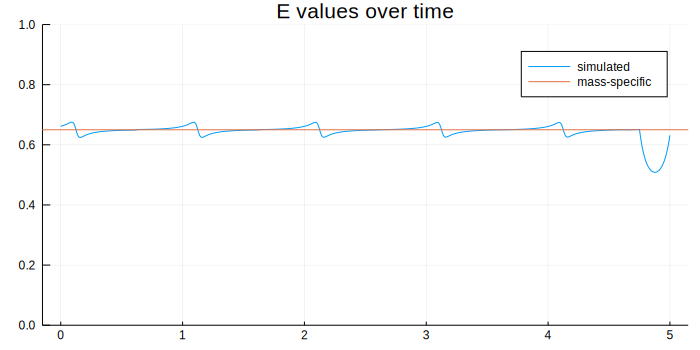

In [863]:
E_vec = Vector{Float64}(undef,length(T))
r2_vec = Vector{Float64}(undef,length(T))

for i  = eachindex(T)
    indx = vcat(collect.( i:(i+25) )...)
    indx[indx .> length(T)] .-= length(T)
    
    data = DataFrame(T = T[indx], R = log.(R[indx]))
    ols = lm(@formula(R ~ T), data)
    E_vec[i] = coef(ols)[2]
    r2_vec[i] = r2(ols)
end

plot(sol.t,E_vec, ylim = (0,1), label = "simulated", title = "E values over time")
hline!([0.65] , label = "mass-specific", size = (700,350))

## $\tau_{T} > \tau_{C}$ - biomass changes alot faster than temperature

In this regime biomass dynamics occur alot faster than temperature. In this way biomass will track temperature perfectly, reaching carrying capacity constantly. If this carrying capaicty is independent of temperature then we should see the smae result as above but if it also changes with temperature then we should see a temperature dependence in the biomass mirroring this.

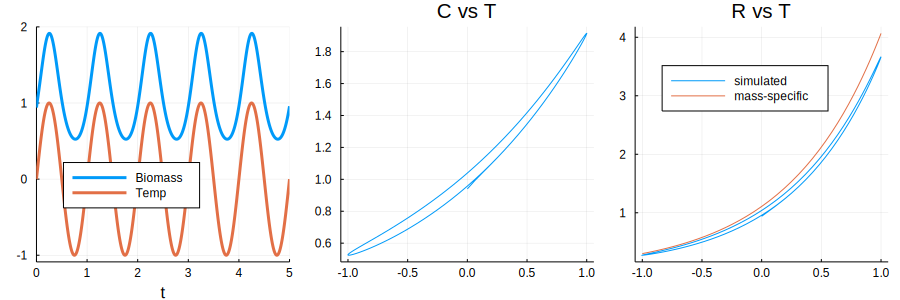

In [866]:
p = parameters(100.0,0.65,
                1.0,0.65, 
                1.0,0.65)

C0 = [0.94,0.0]
tspan = (0.0,5.0)

prob = ODEProblem(dC!,C0,tspan,p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, saveat = 0.01)

p1 = plot(sol, label = ["Biomass" "Temp"], legend = :bottomleft)

C = hcat(sol.u...)[1,:]
T = hcat(sol.u...)[2,:]
R = get_R.(Ref(sol),sol.t) 

p2 = plot(T,C, title = "C vs T", legend = false)

r = boltz.(Ref(b_param(1.0,0.65 * 2)),T) .* mean(C)
p3 = plot(T,R, title = "R vs T", label = "simulated", legend = :topleft)
plot!(p3,T,r, label = "mass-specific")


plot(p1,p2,p3, layout = (1,3), size = (900,300) )

As we can see the biomass in the system responds to temperature when looking at a seasonal scale. when looking at total ecosystem respiration this results in an $E$ value that is greater than the mass-specific respiration and equal to the product of mass-specific repsiration and carrying capacity. 

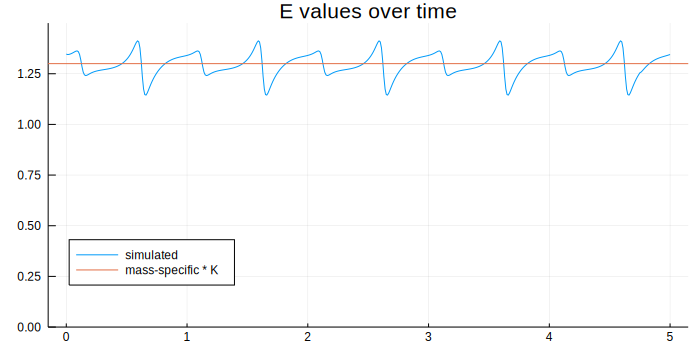

In [867]:
E_vec = Vector{Float64}(undef,length(T))
r2_vec = Vector{Float64}(undef,length(T))

for i  = eachindex(T)
    indx = vcat(collect.( i:(i+25) )...)
    indx[indx .> length(T)] .-= length(T)
    
    data = DataFrame(T = T[indx], R = log.(R[indx]))
    ols = lm(@formula(R ~ T), data)
    E_vec[i] = coef(ols)[2]
    r2_vec[i] = r2(ols)
end

plot(sol.t,E_vec, ylim = (0.0,1.5), label = "simulated", title = "E values over time", legend = :bottomleft)
hline!([2*0.65] , label = "mass-specific * K", size = (700,350))

## $\tau_{T} \approx \tau_{C}$ 


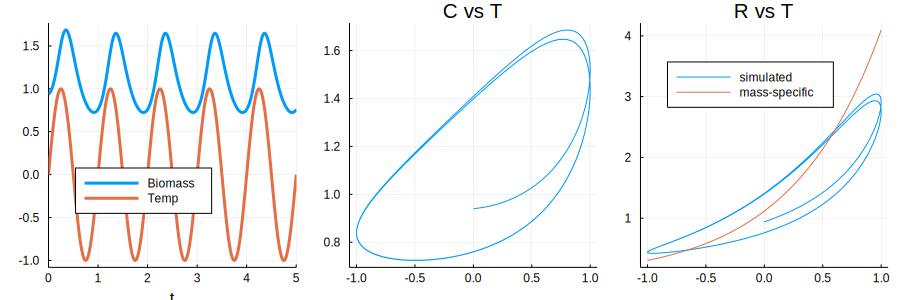

In [911]:
p = parameters(5.0,0.65,
                1.0,0.65, 
                1.0,0.65)

C0 = [0.94,0.0]
tspan = (0.0,5.0)

prob = ODEProblem(dC!,C0,tspan,p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, saveat = 0.01)

p1 = plot(sol, label = ["Biomass" "Temp"], legend = :bottomleft)

C = hcat(sol.u...)[1,:]
T = hcat(sol.u...)[2,:]
R = get_R.(Ref(sol),sol.t) 

p2 = plot(T,C, title = "C vs T", legend = false)

r = boltz.(Ref(b_param(1.0,0.65 * 2)),T) .* mean(C)
p3 = plot(T,R, title = "R vs T", label = "simulated", legend = :topleft)
plot!(p3,T,r, label = "mass-specific")


plot(p1,p2,p3, layout = (1,3), size = (900,300) )

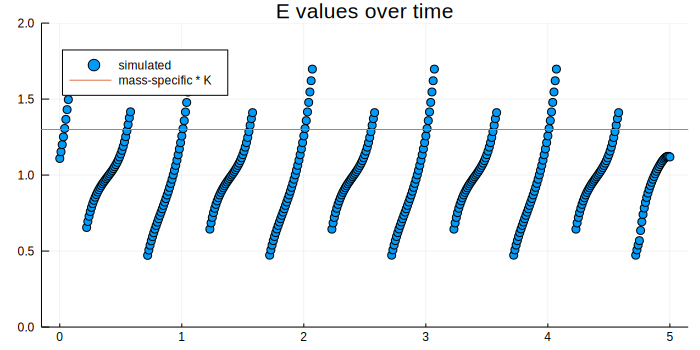

In [912]:
E_vec = Vector{Float64}(undef,length(T))
r2_vec = Vector{Float64}(undef,length(T))

for i  = eachindex(T)
    indx = vcat(collect.( i:(i+25) )...)
    indx[indx .> length(T)] .-= length(T)
    
    data = DataFrame(T = T[indx], R = log.(R[indx]))
    ols = lm(@formula(R ~ T), data)
    E_vec[i] = coef(ols)[2]
    r2_vec[i] = r2(ols)
end
θ = 0.9
scatter(sol.t[r2_vec .> θ],E_vec[r2_vec .> θ], ylim = (0.0,2.0), label = "simulated", title = "E values over time", legend = :topleft)
hline!([2*0.65] , label = "mass-specific * K", size = (700,350))

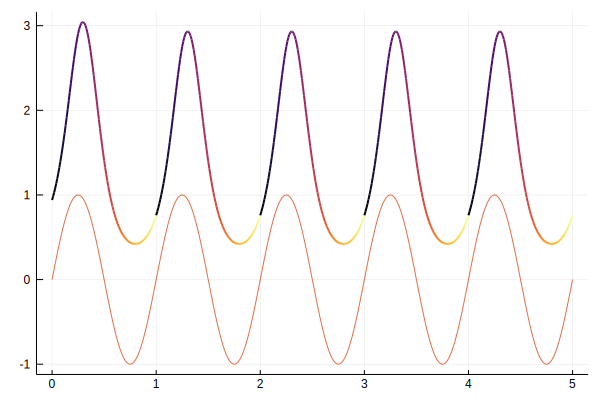

In [913]:
plot(sol.t,R, line_z = sol.t .% 1.0 , linewidth = 2, legend = false)
plot!(sol.t,T)

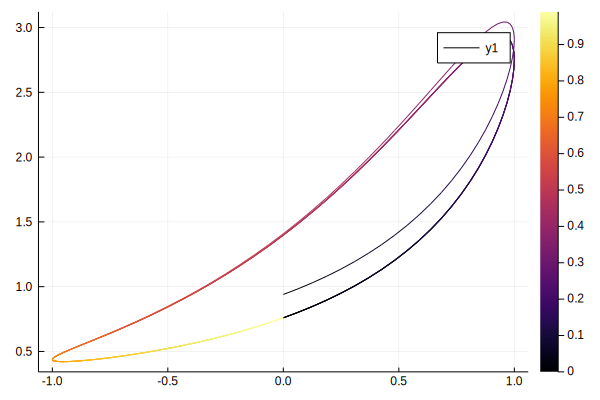

In [914]:
plot(T,R, line_z = sol.t .% 1.0)

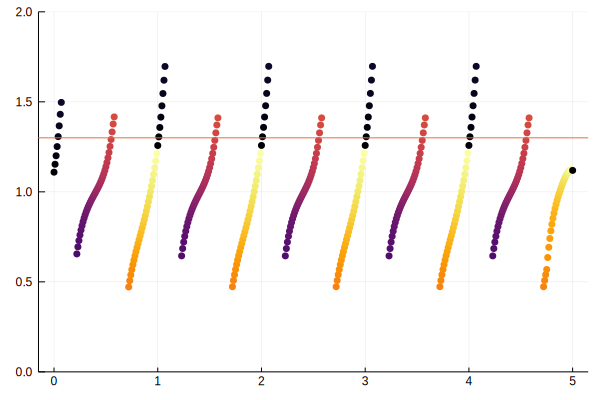

In [916]:
indx = r2_vec .> θ

scatter(sol.t[indx],E_vec[indx], ylim = (0.0,2.0),markerz = sol.t[indx] .% 1.0, legend = false,markerstrokealpha = 0.0)
hline!([2*0.65])

In [942]:
E = Vector{Float64}(undef,12)
σE = Vector{Float64}(undef,12)
confint

for m = 1:12
    tscale = 2 .+  collect( ((float(m)-1.0)/12) : 0.01 : (float(m)/12) )
    R = get_R.(Ref(sol),tscale)
    T = get_T.(Ref(sol),tscale)
    
    data = DataFrame(T = T , R = log.(R))
    ols = lm(@formula(R ~ T), data)
    E[m] = coef(ols)[2]
    σE[m] = E[m] - confint(ols)[2,2]
  
end

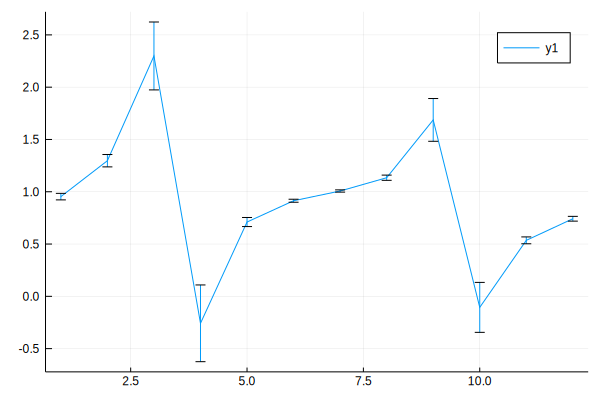

In [943]:
plot(E,yerror = σE)

In [940]:
confint(ols)[2,2]

0.7647387905380432